(test-functions:borehole)=
# Borehole Function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uqtestfuns as uqtf

The Borehole test function is an eight-dimensional scalar-valued function.
The function has been used in the context of sensitivity analysis
{cite}`Harper1983, Worley1987` and metamodeling {cite}`Morris1993`.

## Test function instance

To create a default instance of the Borehole test function:

In [2]:
my_testfun = uqtf.Borehole()

Check if it has been correctly instantiated:

In [3]:
print(my_testfun)

Name              : Borehole
Spatial dimension : 8
Description       : Borehole function from Harper and Gupta (1983)


## Description

The Borehole function models the flow rate of water through a borehole drilled
from the ground surface through two aquifers.
The model assumes laminar-isothermal flow, and there is no groundwater gradient,
with steady-state flow between the upper aquifer and the borehole
and between the borehole and the lower aquifer {cite}`Harper1983`.
The function computes the water flow rate through the borehole
using the following analytical formula:

$$
\mathcal{M}(\boldsymbol{x}) = \frac{2 \, \pi \, T_u \, (H_u - H_l)}{\ln{(r/rw)} \left[1 + \frac{2 \, L \, Tu}{\ln{(r/rw)} \, r_w^2 K_w} + \frac{T_u}{T_l} \right]} 
$$

where $\boldsymbol{x} = \{ r_w, r, T_u, H_u, T_l, H_l, L, K_w\}$
is the vector of input variables defined below.
The unit of the output is $\left[ \mathrm{m}^3 / \mathrm{year} \right]$.

## Probabilistic input

There are two probabilistic input models available as shown in the table below.

|  No.   |        Keyword         |       Source       |  
|:------:|:----------------------:|:------------------:|  
|   1.   | `Harper1983` (default) | {cite}`Harper1983` |  
|   2.   |      `Morris1993`      | {cite}`Morris1993` |

In both specifications, the input variables are modeled as independent random
variables.
The marginals of the original specification (from {cite}`Harper1983`) are shown
below:

In [4]:
my_testfun.prob_input

ProbInput(spatial_dimension=8, marginals=(UnivDist(distribution='normal', parameters=array([0.1      , 0.0161812]), name='rw', description='radius of the borehole [m]'), UnivDist(distribution='lognormal', parameters=array([7.71  , 1.0056]), name='r', description='radius of influence [m]'), UnivDist(distribution='uniform', parameters=array([ 63070., 115600.]), name='Tu', description='transmissivity of upper aquifer [m^2/year]'), UnivDist(distribution='uniform', parameters=array([ 990., 1100.]), name='Hu', description='potentiometric head of upper aquifer [m]'), UnivDist(distribution='uniform', parameters=array([ 63.1, 116. ]), name='Tl', description='transmissivity of lower aquifer [m^2/year]'), UnivDist(distribution='uniform', parameters=array([700., 820.]), name='Hl', description='potentiometric head of lower aquifer [m]'), UnivDist(distribution='uniform', parameters=array([1120., 1680.]), name='L', description='length of the borehole [m]'), UnivDist(distribution='uniform', parameters=array([ 9985., 12045.]), name='Kw', description='hydraulic conductivity of the borehole [m/year]')), copulas=None, name='Borehole-Harper-1983', description='Probabilistic input model of the Borehole model from Harper and Gupta (1983).')

```{note}
In {cite}`Morris1993`,
the non-uniform distributions ($r_w$ and $r$) are replaced
with uniform distributions.
```

For example, to create a Borehole test function using
the input specification by {cite}`Morris1993`:

```python
my_testfun = uqtf.Borehole(prob_input_selection="Morris1993")
```

## Reference results

This section provides several reference results of typical UQ analyses involving
the test function.

### Sample histogram

Shown below is the histogram of the output based on $100'000$ random points:

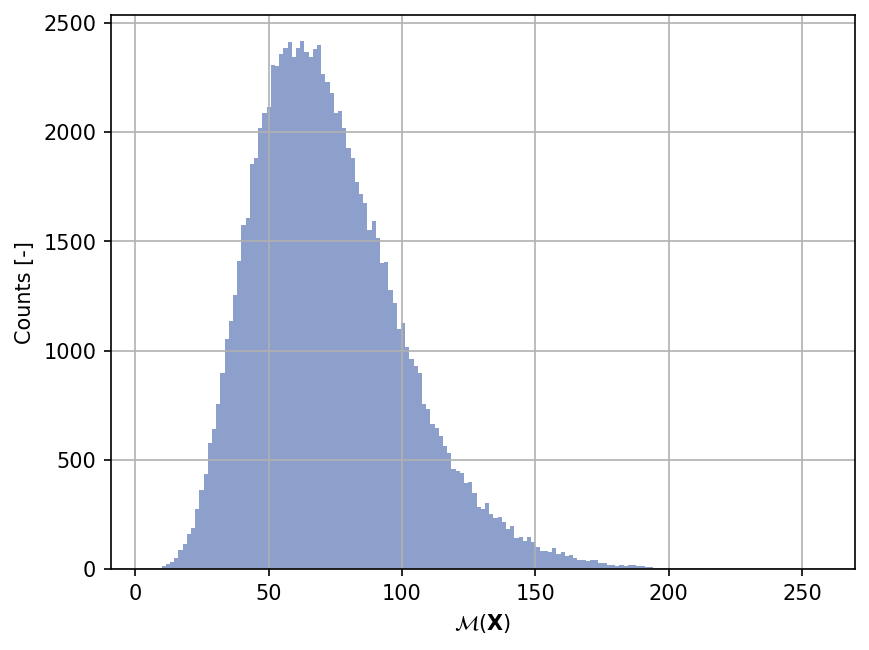

In [5]:
np.random.seed(42)
xx_test = my_testfun.prob_input.get_sample(100000)
yy_test = my_testfun(xx_test)

plt.hist(yy_test, bins="auto", color="#8da0cb");
plt.grid();
plt.ylabel("Counts [-]");
plt.xlabel("$\mathcal{M}(\mathbf{X})$");
plt.gcf().set_dpi(150);

### Moments estimation

Shown below is the convergence of a direct Monte-Carlo estimation of
the output mean and variance with increasing sample sizes.

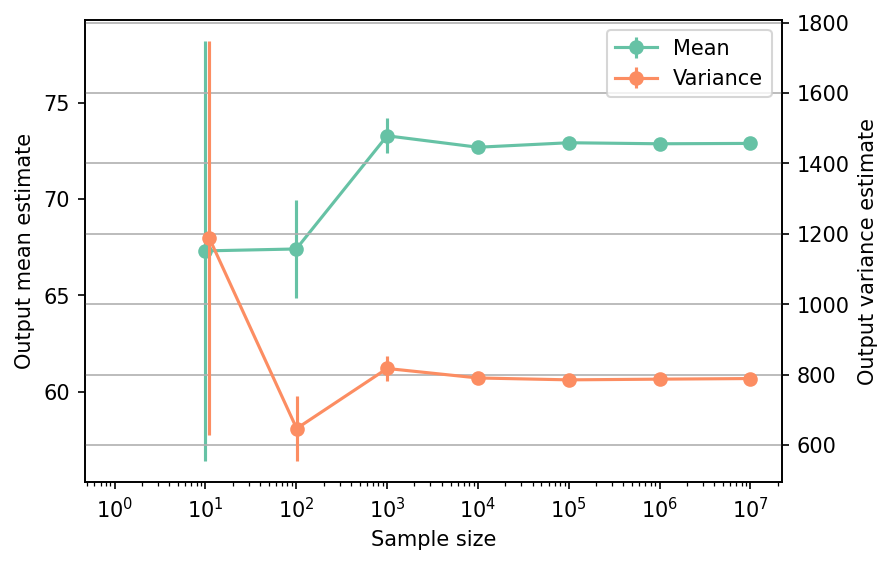

In [6]:
# --- Compute the mean and variance estimate
np.random.seed(42)
sample_sizes = np.array([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7], dtype=int)
mean_estimates = np.empty(len(sample_sizes))
var_estimates = np.empty(len(sample_sizes))

for i, sample_size in enumerate(sample_sizes):
    xx_test = my_testfun.prob_input.get_sample(sample_size)
    yy_test = my_testfun(xx_test)
    mean_estimates[i] = np.mean(yy_test)
    var_estimates[i] = np.var(yy_test)

# --- Compute the error associated with the estimates
mean_estimates_errors = np.sqrt(var_estimates) / np.sqrt(np.array(sample_sizes))
var_estimates_errors = var_estimates * np.sqrt(2 / (np.array(sample_sizes) - 1))

# --- Do the plot
fig, ax_1 = plt.subplots(figsize=(6,4))

ax_1.errorbar(
    sample_sizes,
    mean_estimates,
    yerr=mean_estimates_errors,
    marker="o",
    color="#66c2a5",
    label="Mean",
)
ax_1.set_xlabel("Sample size")
ax_1.set_ylabel("Output mean estimate")
ax_1.set_xscale("log");
ax_2 = ax_1.twinx()
ax_2.errorbar(
    sample_sizes + 1,
    var_estimates,
    yerr=var_estimates_errors,
    marker="o",
    color="#fc8d62",
    label="Variance",
)
ax_2.set_ylabel("Output variance estimate")

# Add the two plots together to have a common legend
ln_1, labels_1 = ax_1.get_legend_handles_labels()
ln_2, labels_2 = ax_2.get_legend_handles_labels()
ax_2.legend(ln_1 + ln_2, labels_1 + labels_2, loc=0)

plt.grid()
fig.set_dpi(150)

The tabulated results for each sample size is shown below.

In [7]:
from tabulate import tabulate

# --- Compile data row-wise
outputs = []
for (
    sample_size,
    mean_estimate,
    mean_estimate_error,
    var_estimate,
    var_estimate_error,
) in zip(
    sample_sizes,
    mean_estimates,
    mean_estimates_errors,
    var_estimates,
    var_estimates_errors,
):
    outputs += [
        [
            sample_size,
            mean_estimate,
            mean_estimate_error,
            var_estimate,
            var_estimate_error,
            "Monte-Carlo",
        ],
    ]

header_names = [
    "Sample size",
    "Mean",
    "Mean error",
    "Variance",
    "Variance error",
    "Remark",
]

tabulate(
    outputs,
    headers=header_names,
    floatfmt=(".1e", ".4e", ".4e", ".4e", ".4e", "s"),
    tablefmt="html",
    stralign="center",
    numalign="center",
)

'<table>\n<thead>\n<tr><th style="text-align: center;"> Sample size </th><th style="text-align: center;">   Mean   </th><th style="text-align: center;"> Mean error </th><th style="text-align: center;"> Variance </th><th style="text-align: center;"> Variance error </th><th style="text-align: center;">  Remark   </th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: center;">   1.0e+01   </td><td style="text-align: center;">6.7300e+01</td><td style="text-align: center;"> 1.0899e+01 </td><td style="text-align: center;">1.1879e+03</td><td style="text-align: center;">   5.6000e+02   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n<tr><td style="text-align: center;">   1.0e+02   </td><td style="text-align: center;">6.7399e+01</td><td style="text-align: center;"> 2.5431e+00 </td><td style="text-align: center;">6.4674e+02</td><td style="text-align: center;">   9.1924e+01   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n<tr><td style="text-align: center;">   1.0e+03   </td><td style="text-align: center;">7.3273e+01</td><td style="text-align: center;"> 9.0406e-01 </td><td style="text-align: center;">8.1732e+02</td><td style="text-align: center;">   3.6570e+01   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n<tr><td style="text-align: center;">   1.0e+04   </td><td style="text-align: center;">7.2679e+01</td><td style="text-align: center;"> 2.8114e-01 </td><td style="text-align: center;">7.9037e+02</td><td style="text-align: center;">   1.1178e+01   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n<tr><td style="text-align: center;">   1.0e+05   </td><td style="text-align: center;">7.2912e+01</td><td style="text-align: center;"> 8.8600e-02 </td><td style="text-align: center;">7.8500e+02</td><td style="text-align: center;">   3.5106e+00   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n<tr><td style="text-align: center;">   1.0e+06   </td><td style="text-align: center;">7.2859e+01</td><td style="text-align: center;"> 2.8053e-02 </td><td style="text-align: center;">7.8697e+02</td><td style="text-align: center;">   1.1129e+00   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n<tr><td style="text-align: center;">   1.0e+07   </td><td style="text-align: center;">7.2878e+01</td><td style="text-align: center;"> 8.8810e-03 </td><td style="text-align: center;">7.8872e+02</td><td style="text-align: center;">   3.5273e-01   </td><td style="text-align: center;">Monte-Carlo</td></tr>\n</tbody>\n</table>'

## References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```